/tmp/ipykernel_554226/1200649436.py:102: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig,


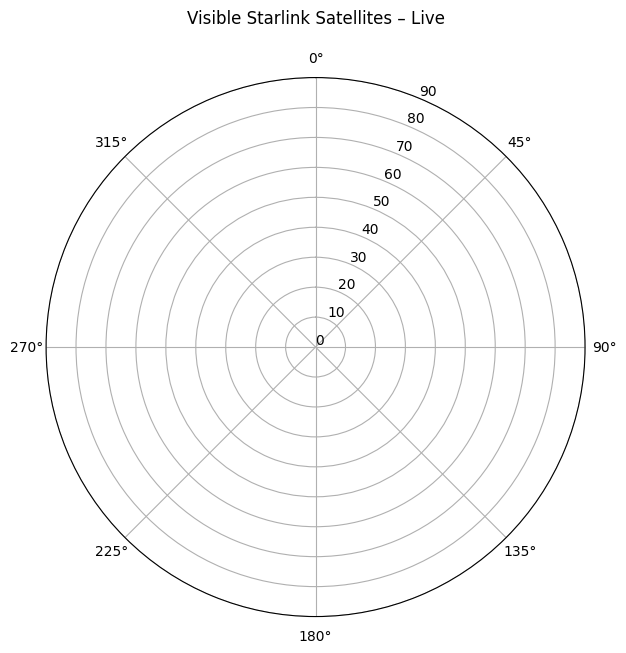

In [ ]:
import numpy as np
import pandas as pd
import requests, datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from skyfield.api import load, EarthSatellite, wgs84

# ───────────────────────────────────────────────────────────────
# CONFIG
# ----------------------------------------------------------------
OBSERVER = dict(lat=40.0822, lon=-105.1092, elev=1_560)   # Boulder, CO
ELEV_MIN_DEG   = 10                                       # min elevation
MAX_SAT_NUMBER = 800                                      # cap for speed
REFRESH_SEC    = 5                                        # animation period

DOT_STYLE = dict(marker='o', s=35,
                 edgecolor='k', linewidth=0.3, alpha=0.9,
                 color='tab:blue')

# ───────────────────────────────────────────────────────────────
# 1) Robust Starlink TLE loader
# ----------------------------------------------------------------
def load_starlink(max_n=MAX_SAT_NUMBER):
    url = ("https://celestrak.com/NORAD/elements/gp.php"
           "?GROUP=starlink&FORMAT=tle")
    text = requests.get(url, timeout=10).text.strip().splitlines()

    ts   = load.timescale()
    sats = []
    for i in range(0, len(text) - 2, 3):        # 只拿完整的 3 行组
        try:
            sats.append(EarthSatellite(text[i+1], text[i+2],
                                       text[i].strip(), ts))
        except ValueError:                      # 行格式坏掉就跳过
            continue
        if len(sats) >= max_n:
            break
    return sats, ts

SAT_LIST, TS = load_starlink()

# ───────────────────────────────────────────────────────────────
# 2) Helper: visible satellites → DataFrame
# ----------------------------------------------------------------
OBSERV_TOPOS = wgs84.latlon(OBSERVER['lat'],
                            OBSERVER['lon'],
                            OBSERVER['elev'])

def visible_starlinks(ts, sats, elev_min=ELEV_MIN_DEG):
    t_now = ts.now()
    rows  = []
    for sat in sats:
        alt, az, _ = (sat - OBSERV_TOPOS).at(t_now).altaz()
        if alt.degrees >= elev_min:
            rows.append([sat.name, az.degrees, alt.degrees])
    return pd.DataFrame(rows, columns=['Name', 'Azimuth', 'Elevation'])

# ───────────────────────────────────────────────────────────────
# 3) Build polar plot
# ----------------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='polar')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_rticks(range(0, 91, 10))
ax.set_title("Visible Starlink Satellites – Live", pad=20)

scat   = ax.scatter([], [], **DOT_STYLE)
empty_xy = np.empty((0, 2))
annot  = ax.text(0.5, -0.08, '', ha='center', va='top',
                 transform=ax.transAxes, fontsize=9)

# ───────────────────────────────────────────────────────────────
# 4) Animation
# ----------------------------------------------------------------
def init():
    scat.set_offsets(empty_xy)
    annot.set_text('')
    return scat, annot

def update(_):
    df = visible_starlinks(TS, SAT_LIST)
    if df.empty:
        scat.set_offsets(empty_xy)
        annot.set_text(f"No sats ≥ {ELEV_MIN_DEG}°  "
                       f"{datetime.datetime.now():%H:%M:%S}")
        return scat, annot

    theta = np.radians(df['Azimuth'].values)
    r     = df['Elevation'].values
    scat.set_offsets(np.c_[theta, r])

    annot.set_text(f"{len(df)} sats   "
                   f"{datetime.datetime.now():%H:%M:%S}")
    return scat, annot

ani = FuncAnimation(fig,
                    update,
                    init_func=init,
                    interval=REFRESH_SEC*1000,
                    blit=False)        

plt.show()


/tmp/ipykernel_554226/1826282671.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


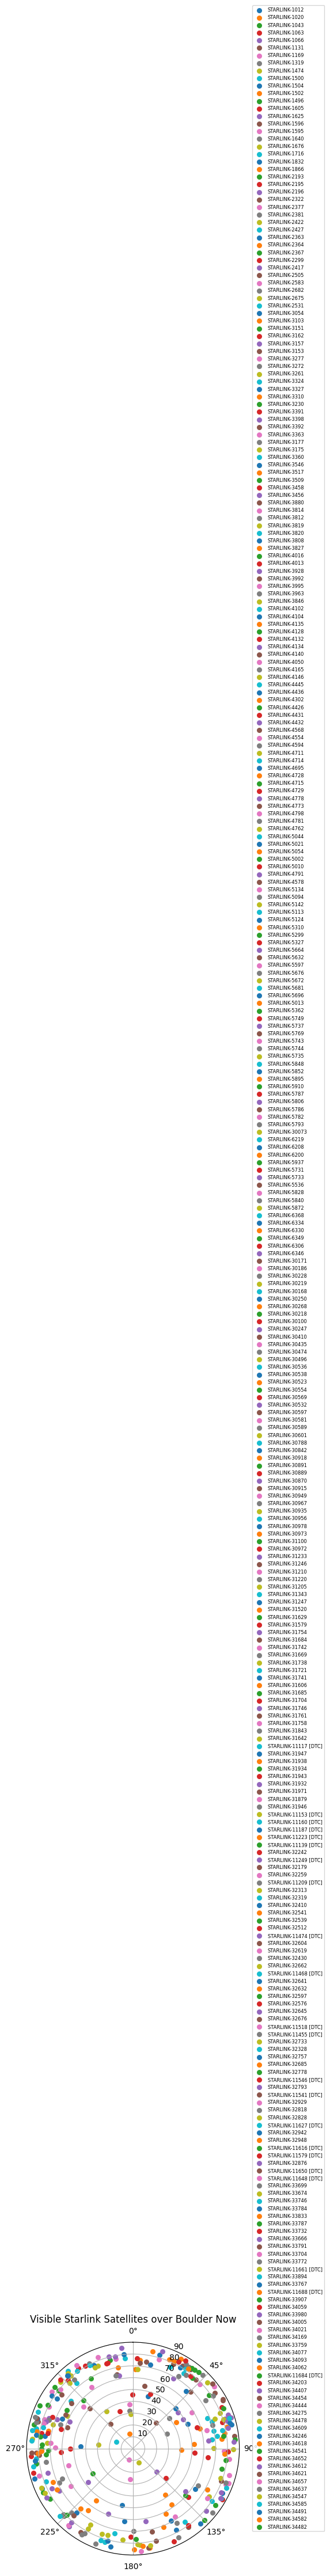

In [2]:
import requests
from skyfield.api import load, EarthSatellite, Topos
import matplotlib.pyplot as plt

#  Near Boulder 
lat, lon, elev = 40.0822, -105.1092, 1560  # degrees, degrees, meters
observer = Topos(latitude_degrees=lat, longitude_degrees=lon, elevation_m=elev)


ts = load.timescale()
t = ts.now()


url = 'https://celestrak.com/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
tle_lines = requests.get(url).text.strip().split('\n')


sats = []
for i in range(0, len(tle_lines), 3):
    name = tle_lines[i].strip()
    line1 = tle_lines[i+1].strip()
    line2 = tle_lines[i+2].strip()
    sat = EarthSatellite(line1, line2, name, ts)
    sats.append((name, sat))

visible_sats = []
for name, sat in sats:
    alt, az, _ = (sat - observer).at(t).altaz()
    if alt.degrees > 3:
        visible_sats.append((name, az.degrees, alt.degrees))


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')  # North 0°
ax.set_theta_direction(-1)      

for name, az, alt in visible_sats:
    ax.scatter(
        az * (3.1416 / 180),     # azimuth in radians
        90 - alt,                
        label=name, s=30)

ax.set_rlim(0, 90)  # 0 to 90 
ax.set_title("Visible Starlink Satellites over Boulder Now", fontsize=12)
ax.legend(fontsize=6, loc='lower left', bbox_to_anchor=(1.05, 0.1))
plt.tight_layout()
plt.show()


/tmp/ipykernel_554226/1176215922.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


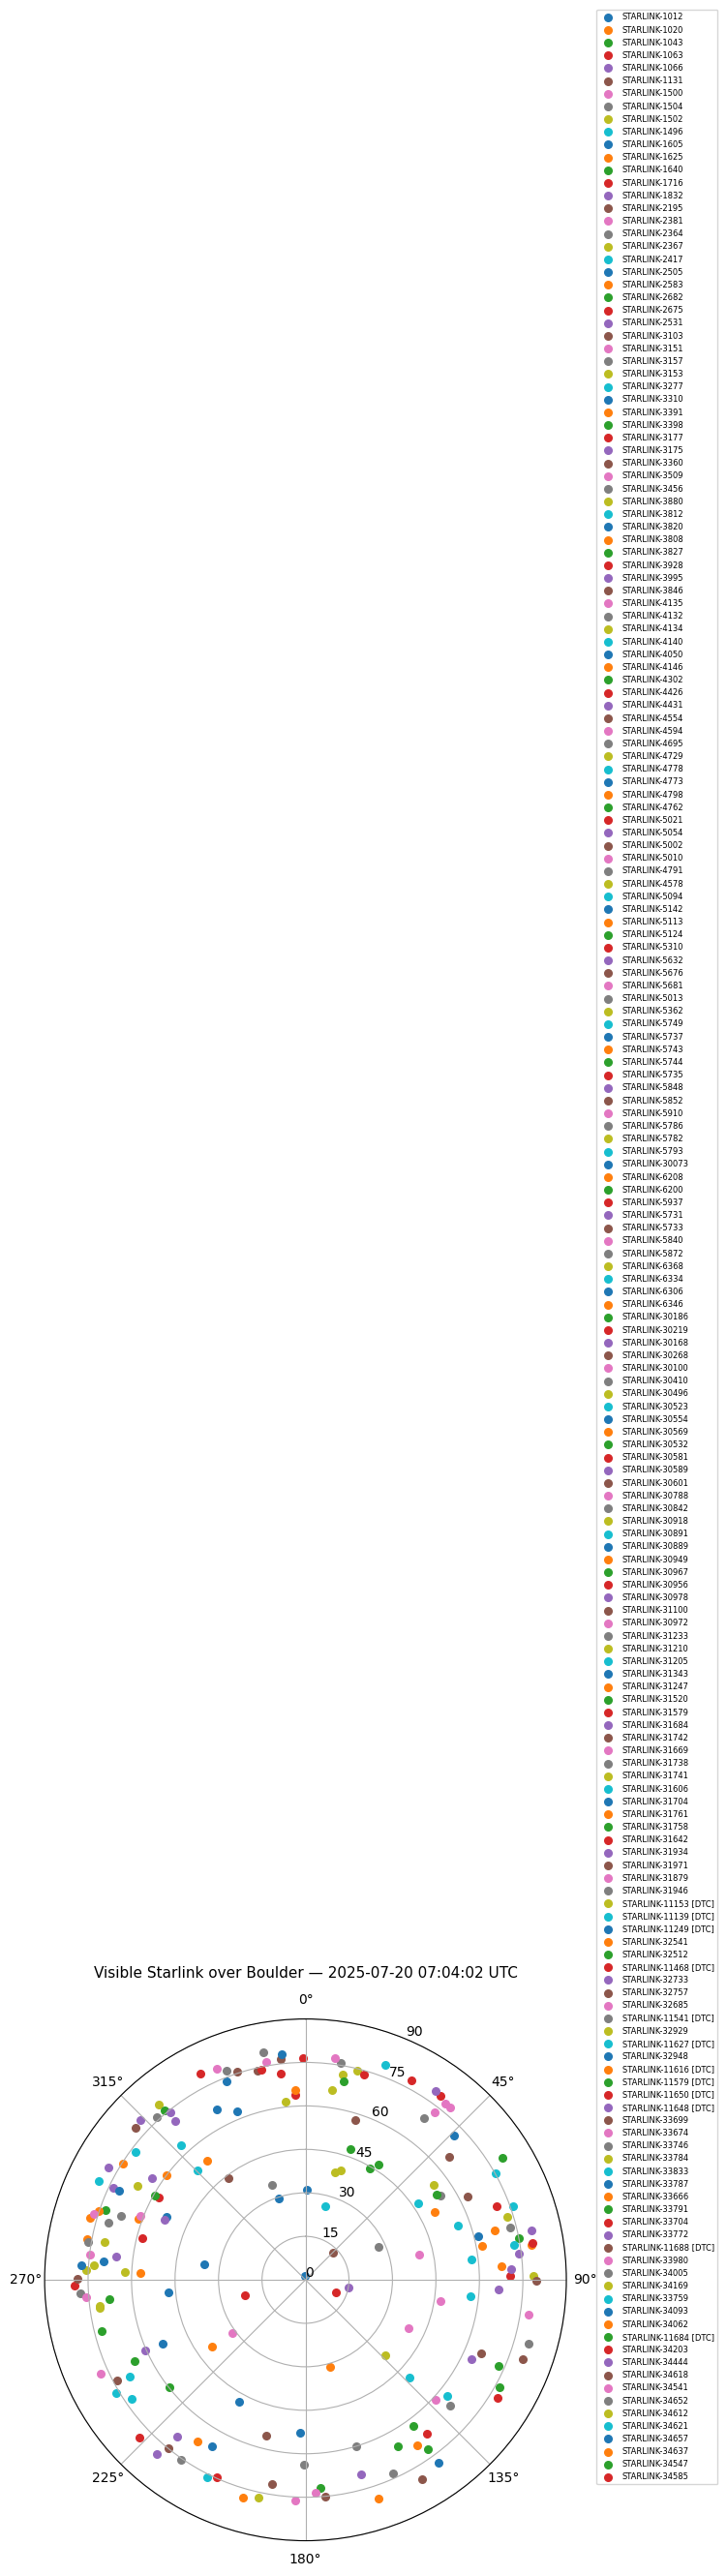

In [3]:
import requests, datetime
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, EarthSatellite, Topos

# --------------------------------------------------------------
# Observer (Boulder, CO)
lat, lon, elev = 40.0822, -105.1092, 1560     # °, °, m
observer = Topos(latitude_degrees=lat,
                 longitude_degrees=lon,
                 elevation_m=elev)

# --------------------------------------------------------------
# Grab Starlink TLEs (robust)
url = ("https://celestrak.com/NORAD/elements/gp.php"
       "?GROUP=starlink&FORMAT=tle")

resp = requests.get(url, timeout=10)
lines = [ln.strip() for ln in resp.text.splitlines() if ln.strip()]

ts   = load.timescale()
sats = []
for i in range(0, len(lines) - 2, 3):          # only full 3-line blocks
    name, l1, l2 = lines[i], lines[i+1], lines[i+2]
    # skip corrupt groups that don't start with "1 " / "2 "
    if not (l1.startswith('1 ') and l2.startswith('2 ')):
        continue
    try:
        sats.append((name, EarthSatellite(l1, l2, name, ts)))
    except ValueError:
        pass    # bad checksum → skip

# --------------------------------------------------------------
# Find visible satellites
t_now = ts.now()
visible = []
for name, sat in sats:
    alt, az, _ = (sat - observer).at(t_now).altaz()
    if alt.degrees > 10:
        visible.append((name, az.degrees, alt.degrees))

# --------------------------------------------------------------
# Polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7, 7))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_rticks(range(0, 91, 15))
ax.set_title(f"Visible Starlink over Boulder — {t_now.utc_datetime():%Y-%m-%d %H:%M:%S} UTC",
             fontsize=11, pad=12)

for name, az_deg, alt_deg in visible:
    ax.scatter(np.radians(az_deg), 90 - alt_deg, s=30, label=name)

if visible:
    ax.legend(fontsize=6, loc='lower left', bbox_to_anchor=(1.05, 0.1))
else:
    ax.text(0.5, 0.5, "No satellites\nabove 10°", ha='center', va='center',
            transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


In [5]:
print(f"Loaded {len(sats)} Starlinks")
print("Highest elevation right now:",
      max((alt for _,_,alt in visible), default="none"))


Loaded 7956 Starlinks
Highest elevation right now: 88.67445187359098


In [ ]:
import requests
from skyfield.api import load, EarthSatellite

def get_starlink_sats(max_n=800):
    urls = [
        # main CGI (blocked for you right now)
        "https://celestrak.com/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle",
        # static mirror on a different domain
        "https://celestrak.org/NORAD/elements/starlink.txt",
        # third-party daily mirror
        "https://tle.inf.lpda.de/Starlink",
    ]

    # send a browser-like UA to reduce 403s
    headers = {"User-Agent": "Mozilla/5.0"}

    ts   = load.timescale()
    for link in urls:
        try:
            r = requests.get(link, timeout=10, headers=headers)
            if r.status_code != 200 or len(r.content) < 1000:
                print(f"Skip {link}  status {r.status_code} bytes {len(r.content)}")
                continue

            lines = [ln.strip() for ln in r.text.splitlines() if ln.strip()]
            sats  = []
            for i in range(0, len(lines) - 2, 3):
                l1, l2 = lines[i+1], lines[i+2]
                if not (l1.startswith("1 ") and l2.startswith("2 ")):
                    continue                    # line pair malformed
                try:
                    sats.append(EarthSatellite(l1, l2, lines[i], ts))
                except ValueError:
                    continue                    # checksum mismatch
                if len(sats) >= max_n:
                    break

            if sats:                            # success!
                print(f"Loaded {len(sats)} TLEs from {link}")
                return sats, ts

        except requests.RequestException as e:
            print("Fetch failed:", link, e)

    raise RuntimeError("All Starlink TLE mirrors failed")
